**This notebook is an exercise in the [Time Series](https://www.kaggle.com/learn/time-series) course.  You can reference the tutorial at [this link](https://www.kaggle.com/ryanholbrook/trend).**

---



# Introduction #

Run this cell to set everything up!

In [1]:
# Setup notebook
from pathlib import Path
#from learntools.time_series.style import *  # plot style settings

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.linear_model import LinearRegression

plt.style.use("seaborn-whitegrid")
plt.rc(
    "figure",
    autolayout=True,
    figsize=(11, 4),
    titlesize=18,
    titleweight='bold',
)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
%config InlineBackend.figure_format = 'retina'

data_dir = Path('ts-course-data/')
comp_dir = Path('store-sales-time-series-forecasting')

retail_sales = pd.read_csv(
    data_dir / "us-retail-sales.csv",
    parse_dates=['Month'],
    index_col='Month',
).to_period('D')
food_sales = retail_sales.loc[:, 'FoodAndBeverage']
auto_sales = retail_sales.loc[:, 'Automobiles']

dtype = {
    'store_nbr': 'category',
    'family': 'category',
    'sales': 'float32',
    'onpromotion': 'uint64',
}
store_sales = pd.read_csv(
    comp_dir / 'train.csv',
    dtype=dtype,
    parse_dates=['date'],
    infer_datetime_format=True,
)
store_sales = store_sales.set_index('date').to_period('D')
store_sales = store_sales.set_index(['store_nbr', 'family'], append=True)
average_sales = store_sales.groupby('date').mean()['sales']

-------------------------------------------------------------------------------

# 1) Determine trend with a moving average plot

The *US Retail Sales* dataset contains monthly sales data for a number of retail industries in the United States. Run the next cell to see a plot of the *Food and Beverage* series.

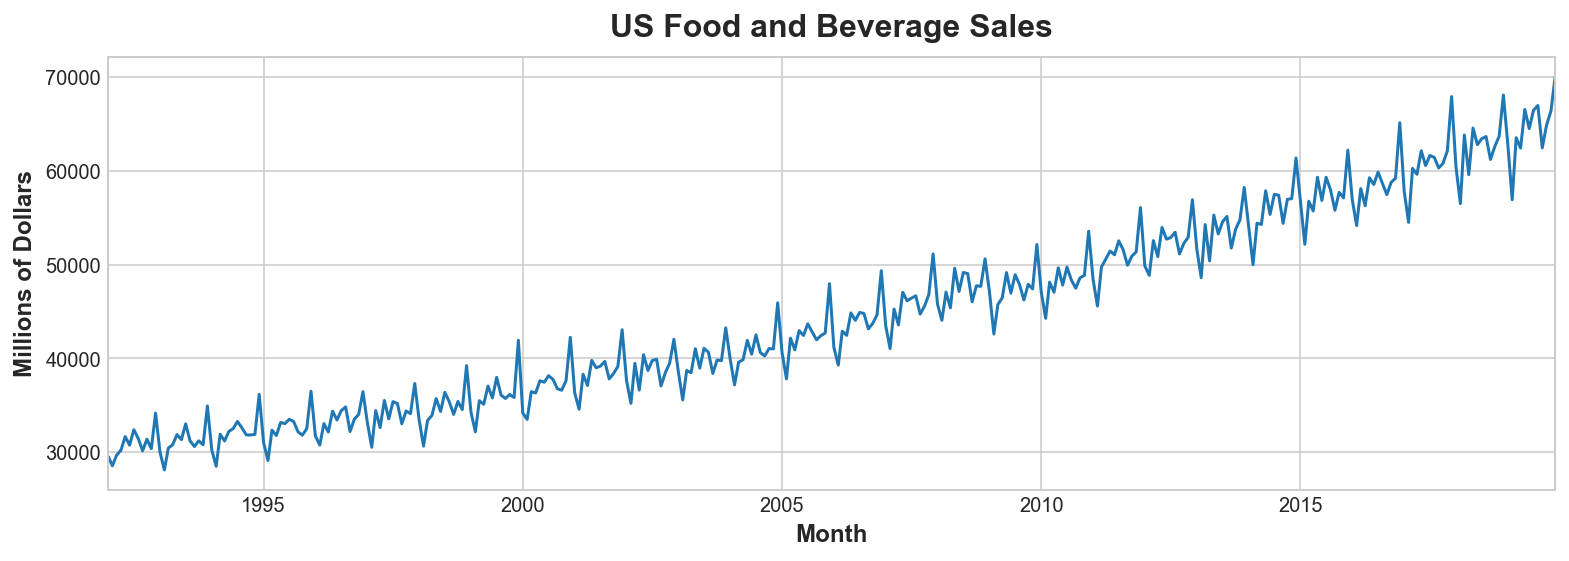

In [2]:
ax = food_sales.plot()
ax.set(title="US Food and Beverage Sales", ylabel="Millions of Dollars");

Now make a moving average plot to estimate the trend for this series.

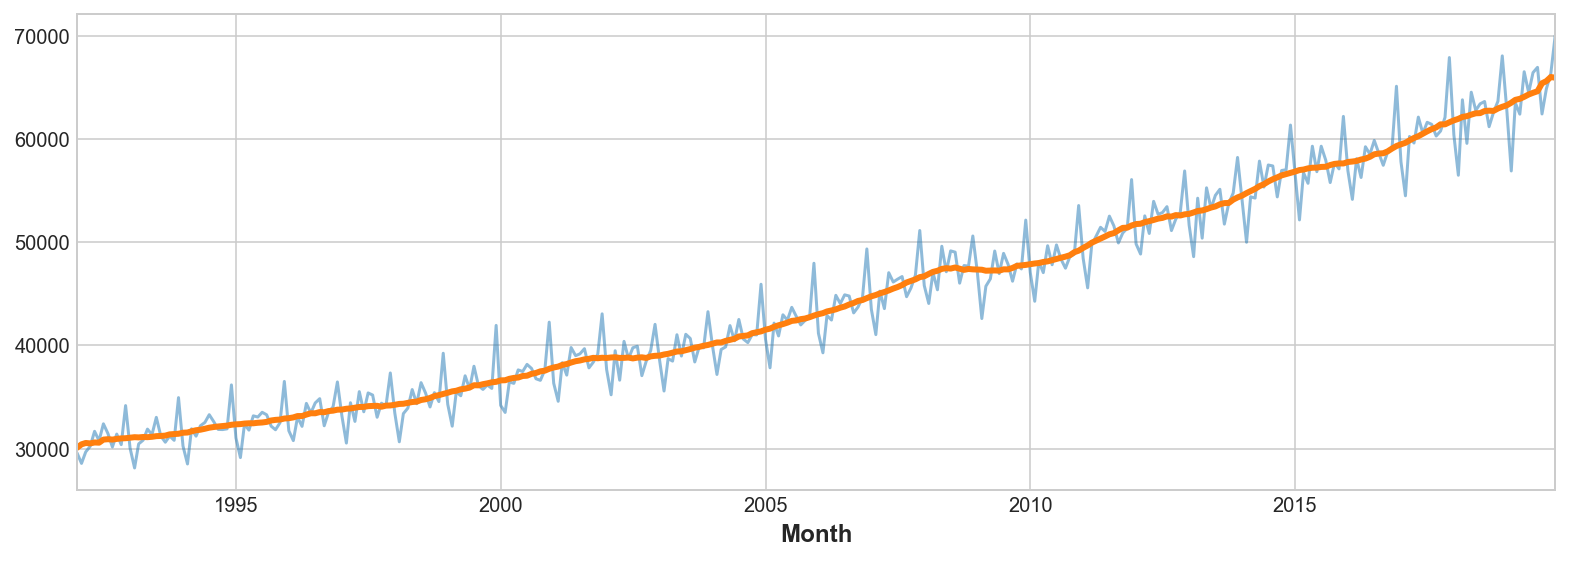

In [3]:
# YOUR CODE HERE: Add methods to `food_sales` to compute a moving
# average with appropriate parameters for trend estimation.
trend = food_sales.rolling(window=12, center=True, min_periods=6).mean()

# Make a plot
ax = food_sales.plot(alpha=0.5)
ax = trend.plot(ax=ax, linewidth=3)

-------------------------------------------------------------------------------

# 2) Identify trend

What order polynomial trend might be appropriate for the *Food and Beverage Sales* series? Can you think of a non-polynomial curve that might work even better?

Once you've thought about it, run this cell for some discussion.

Correct:

The upwards bend in the trend suggests an order 2 (quadratic) polynomial might be appropriate.

If you've worked with economic time series before, you might guess that the growth rate in Food and Beverage Sales is best expressed as a percent change. Percent change can often be modeled using an exponential curve. (Don't worry if this isn't familiar!)

-------------------------------------------------------------------------------

We'll continue using the time series of average sales in this lesson. Run this cell to see a moving average plot of `average_sales` estimating the trend.

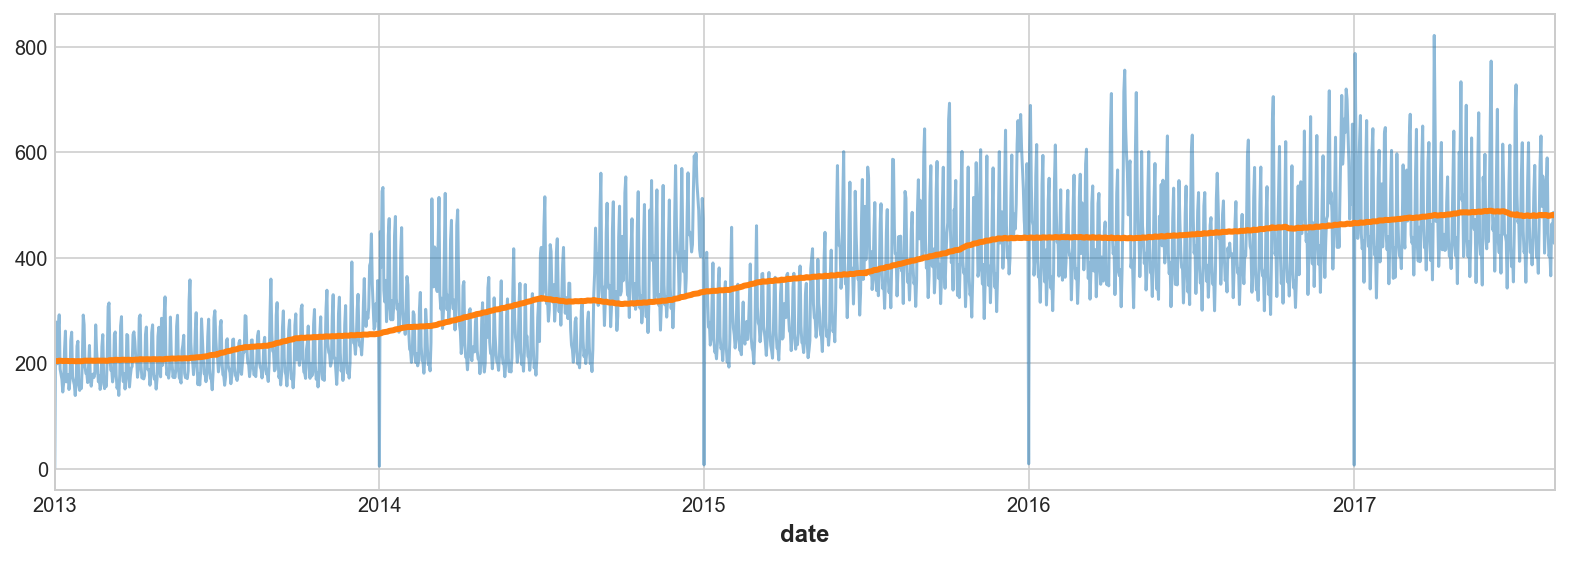

In [4]:
trend = average_sales.rolling(
    window=365,
    center=True,
    min_periods=183,
).mean()

ax = average_sales.plot(alpha=0.5)
ax = trend.plot(ax=ax, linewidth=3)

# 3) Create a Trend Feature

Use `DeterministicProcess` to create a feature set for a cubic trend model. Also create features for a 90-day forecast.

In [5]:
from statsmodels.tsa.deterministic import DeterministicProcess

y = average_sales.copy()  # the target

# YOUR CODE HERE: Instantiate `DeterministicProcess` with arguments
# appropriate for a cubic trend model
dp = DeterministicProcess(index=average_sales.index, order=3, drop=True)

# YOUR CODE HERE: Create the feature set for the dates given in y.index
X = dp.in_sample()

# YOUR CODE HERE: Create features for a 90-day forecast.
X_fore = dp.out_of_sample(steps=90)

C:\Users\myesi\anaconda3\lib\site-packages\statsmodels\compat\pandas.py:61: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


You can see the a plot of the result by running the next cell.

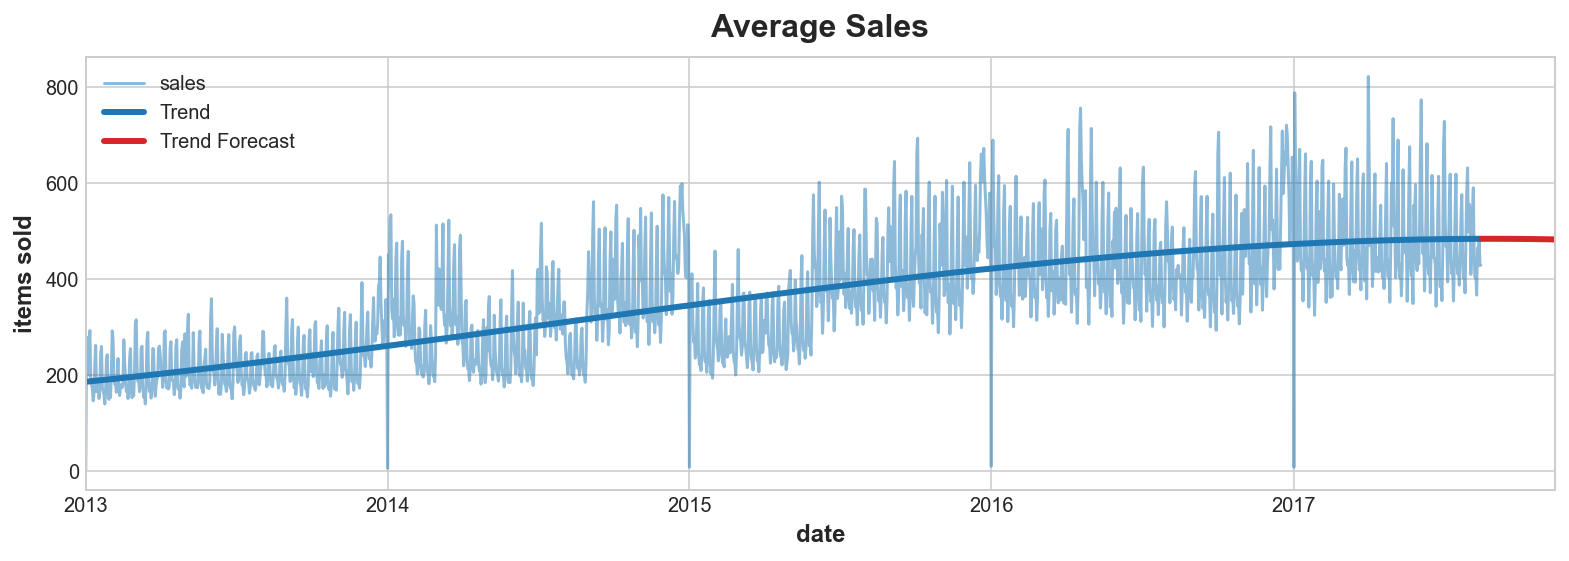

In [6]:
model = LinearRegression()
model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=X.index)
y_fore = pd.Series(model.predict(X_fore), index=X_fore.index)

ax = y.plot(alpha=0.5, title="Average Sales", ylabel="items sold")
ax = y_pred.plot(ax=ax, linewidth=3, label="Trend", color='C0')
ax = y_fore.plot(ax=ax, linewidth=3, label="Trend Forecast", color='C3')
ax.legend();

--------------------------------------------------------------------------------

One way to fit more complicated trends is to increase the order of the polynomial you use. To get a better fit to the somewhat complicated trend in *Store Sales*, we could try using an order 11 polynomial.

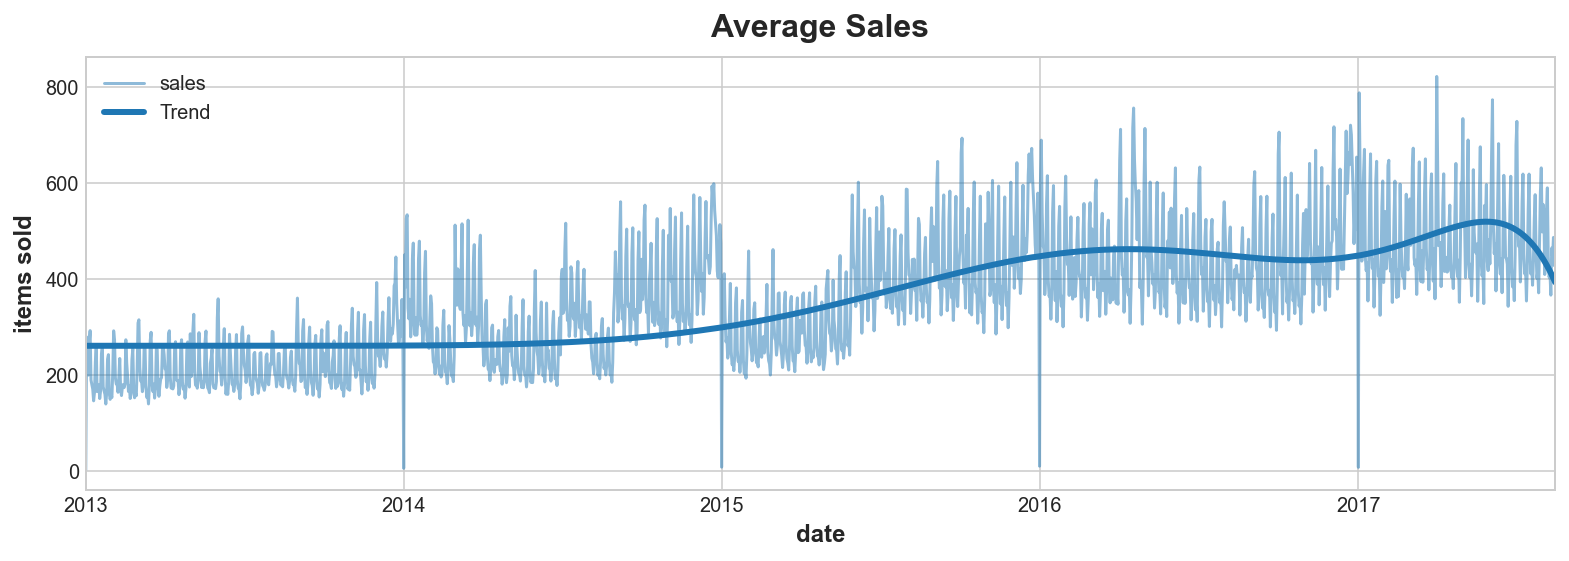

In [7]:
from statsmodels.tsa.deterministic import DeterministicProcess

dp = DeterministicProcess(index=y.index, order=11)
X = dp.in_sample()

model = LinearRegression()
model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=X.index)

ax = y.plot(alpha=0.5, title="Average Sales", ylabel="items sold")
ax = y_pred.plot(ax=ax, linewidth=3, label="Trend", color='C0')
ax.legend();

# 4) Understand risks of forecasting with high-order polynomials

High-order polynomials are generally not well-suited to forecasting, however. Can you guess why?

Correct:

An order 11 polynomial will include terms like t ** 11. Terms like these tend to diverge rapidly outside of the training period making forecasts very unreliable.

Run this cell to see the same 90-day forecast using an order 11 polynomial. Does it confirm your intuition?

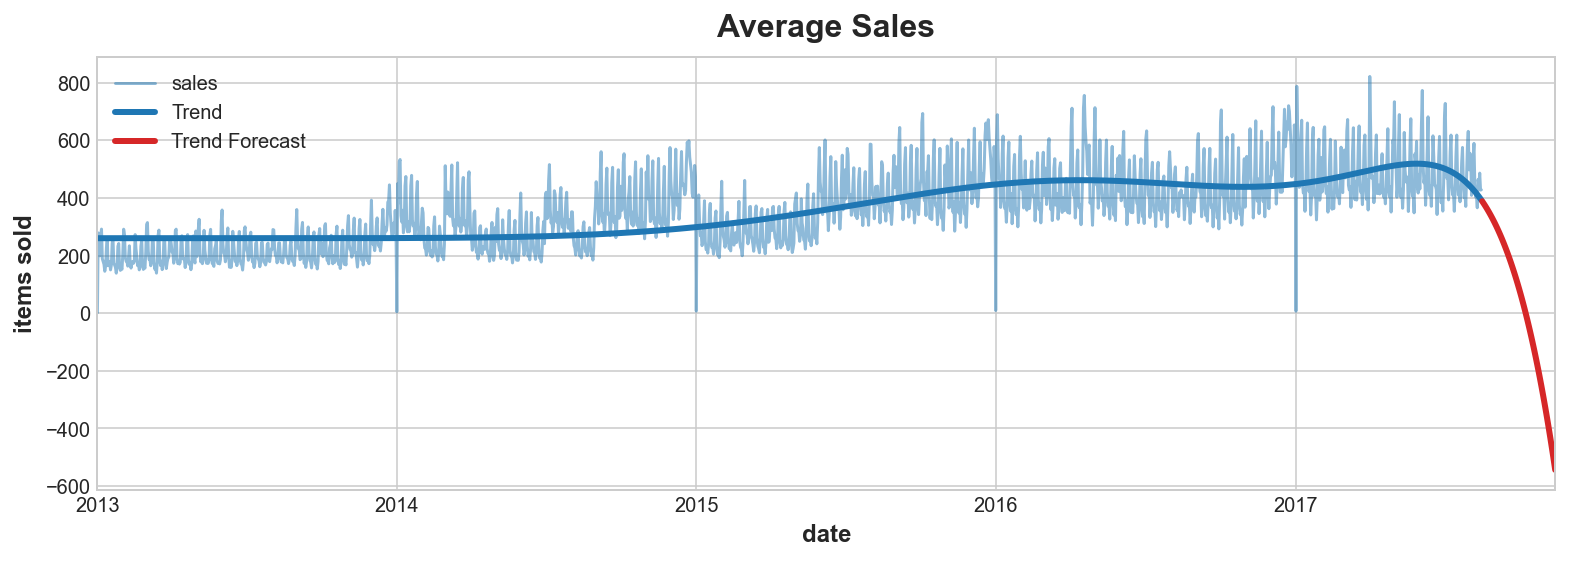

In [8]:
X_fore = dp.out_of_sample(steps=90)
y_fore = pd.Series(model.predict(X_fore), index=X_fore.index)

ax = y.plot(alpha=0.5, title="Average Sales", ylabel="items sold")
ax = y_pred.plot(ax=ax, linewidth=3, label="Trend", color='C0')
ax = y_fore.plot(ax=ax, linewidth=3, label="Trend Forecast", color='C3')
ax.legend();

--------------------------------------------------------------------------------

# (Optional) Fit trend with splines

*Splines* are a nice alternative to polynomials when you want to fit a trend. The *Multivariate Adaptive Regression Splines* (MARS) algorithm in the `pyearth` library is powerful and easy to use. There are a lot of hyperparameters you may want to investigate.

In [ ]:
from pyearth import Earth

# Target and features are the same as before
y = average_sales.copy()
dp = DeterministicProcess(index=y.index, order=1)
X = dp.in_sample()

# Fit a MARS model with `Earth`
model = Earth()
model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=X.index)

ax = y.plot(title="Average Sales", ylabel="items sold")
ax = y_pred.plot(ax=ax, linewidth=3, label="Trend")

<figure style="padding: 1em;">
<img src="assets/trend_4.png" width=800, alt="">
</figure>

Forecasting complicated trends like this will typically be difficult (if not impossible). With historical data, however, you can use splines to isolate other patterns in a time series by *detrending*.

In [ ]:
y_detrended = y - y_pred   # remove the trend from store_sales

y_detrended.plot(**plot_params, title="Detrended Average Sales");

<figure style="padding: 1em;">
<img src="assets/trend_5.png" width=800, alt="">
</figure>

# Keep Going #

[**Model seasonality**](https://www.kaggle.com/ryanholbrook/seasonality), another common type of time dependence, with indicators and Fourier features.

---




*Have questions or comments? Visit the [course discussion forum](https://www.kaggle.com/learn/time-series/discussion) to chat with other learners.*